In [75]:
%matplotlib inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logger = logging.getLogger()

5 Link Analysis
========

### 5.1 PageRank
#### 5.1.1 Eearly Search Engines and Term Spam
**inverted index**:     
a data structure that makes it easy to find all the palces where that a term given occurs.

**term spam**:    
techniques for fooling search engines.

To combat term spam, Google introduced two innovations:

1. PageRank was used to simulate where Web surfers.  $\gets$ random surfer.

2. Use those links that links to the page.  $\gets$ "vote with their feet."


#### 5.1.2 Definiton of PageRank
intent: the higher the PageRank of a page, the more "important" it is.

**transition matrix**:    
to describe what happens to random surfers after one stop.    
$m_{ij} = \frac{1}{k}$ if page $j$ has $k$ arcs out, and one of them is to page $i$.     
Otherwise, $m_{ij} = 0$.

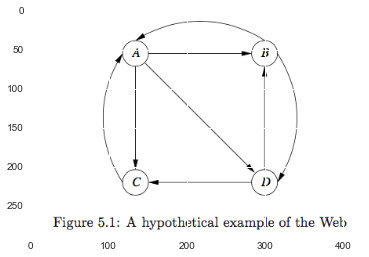

In [76]:
plt.imshow(plt.imread('./res/fig_5_1.png'))

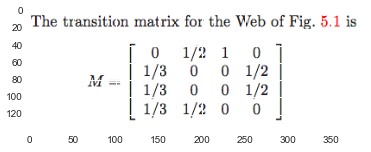

In [77]:
plt.imshow(plt.imread('./res/eg_5_1.png'))

PageRank $v$ simulate random surfers: 

1. start at a random page of all $n$.    
   $v_i^0 = \frac{1}{n} \quad i = 1, 2, \dotsc, n$.
   
2. randomly choose next page linked.     
   $v^{k+1} = M v^{k}$     
   give us the distribution of the surfer after $k+1$ stpes.

In [78]:
# eg. 5.1
matrix_5_1 = np.array([
                [0, 1/3, 1/3, 1/3],
                [1/2, 0, 0, 1/2],
                [1, 0, 0, 0],
                [0, 1/2, 1/2, 0]
             ]).T

matrix_5_1

array([[ 0.        ,  0.5       ,  1.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [79]:
n = matrix_5_1.shape[1]

v = np.ones((n,1)) / n
v

array([[ 0.25],
       [ 0.25],
       [ 0.25],
       [ 0.25]])

In [80]:
def dist_after_surfing(M, v=None, steps=1):
    if v is None:
        n = M.shape[1]
        v = ones((n,1)) / n
        
    for __ in xrange(steps):
        v = M.dot(v)
        
    return v

steps = 1
v_ = dist_after_surfing(matrix_5_1, v, steps)
v_

array([[ 0.375     ],
       [ 0.20833333],
       [ 0.20833333],
       [ 0.20833333]])

**Markov processes**:     
It is known that the distribution of the surfer approaches a limiting distribution $v$ that satisfies $v = Mv$, provided two conditions are met: 

1. The graph is trongly connnected.     
   namely, it is possible to get from any node to any other node.
   
2. There are no dead ends.

eigenvalue and eigenvector: $Mx = \lambda x$    
$v = x : \lambda = 1 \text{ and } \sum_j x_{ij} = 1 \text{ for every } i$.

$v$ is a [stochastic vector](http://www.math.harvard.edu/~knill/teaching/math19b_2011/handouts/lecture33.pdf), and $M$ is a [stochastic/Markov matrix](https://en.wikipedia.org/wiki/Stochastic_matrix).

**Iteration** $O(M^2)$ is better than **Gaussian elimination** $O(M^3)$.

in practice, for the Web itself, 50-75 itreations are sufficient to converge to within the error limits of double-precision arithmetic.

In [81]:
# eg 5.2
v_ = dist_after_surfing(matrix_5_1, v, 10)
v_

array([[ 0.33325195],
       [ 0.22224935],
       [ 0.22224935],
       [ 0.22224935]])

In [82]:
v_ = dist_after_surfing(matrix_5_1, v, 50)
v_

array([[ 0.33333333],
       [ 0.22222222],
       [ 0.22222222],
       [ 0.22222222]])

In [83]:
v_ = dist_after_surfing(matrix_5_1, v, 75)
v_

array([[ 0.33333333],
       [ 0.22222222],
       [ 0.22222222],
       [ 0.22222222]])

#### 5.1.3 Structure of the Web
Some structures in reality violate the assumptions needed for the Markov-process iteration to converge to a limit.

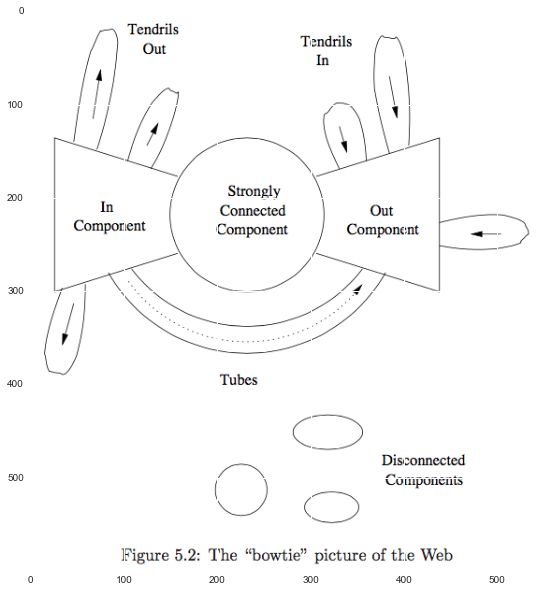

In [84]:
plt.figure(figsize = (10,10))
plt.imshow(plt.imread('./res/fig_5_2.png'))

**Two problems** we need to avoid by modifing PageRank:

1. the dead end.

2. spider traps.     
   the groups of pages that all have outlinks but they never link to any other pages.

#### 5.1.4 Avoiding Dead Ends
Dead Ends $\to$ $M$ is no longer stochastic, since some of the columns will sum to 0 rather than 1.

If we compute $M^iv$ and $M$ is substochastic, then some or all of the components of the vector go to 0.

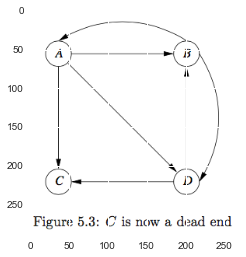

In [85]:
# eg 5.3
plt.imshow(plt.imread('./res/fig_5_3.png'))

In [86]:
M = np.array([
        [0, 1/3, 1/3, 1/3],
        [1/2, 0, 0, 1/2],
        [0, 0, 0, 0],
        [0, 1/2, 1/2, 0]
    ]).T

M

array([[ 0.        ,  0.5       ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [87]:
dist_after_surfing(M, v, 50)

array([[  2.55407417e-08],
       [  3.72237693e-08],
       [  3.72237693e-08],
       [  3.72237693e-08]])

##### Two Solutions
###### 1. Drop the dead end      
   recursive deletion of dead ends, and solve the remaining graph $G'$.     
   then we restore $G$ from $G'$, recursivly.     
   $$ e = \sum \frac{v_p}{k_p} $$    
   where $e \in (G - G')$, $p \in G'$ and is the predecessor of $e$, $k$ is the number of successors of $p$ in $G$.

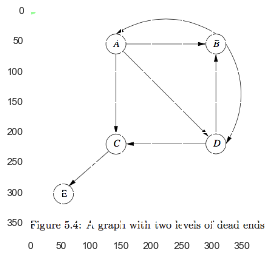

In [88]:
# eg 5.4
plt.imshow(plt.imread('./res/fig_5_4.png'))

In [89]:
M_G = np.array([
        [0, 1/3, 1/3, 1/3, 0],
        [1/2, 0, 0, 1/2, 0],
        [0, 0, 0, 0, 1],
        [0, 1/2, 1/2, 0, 0],
        [0, 0, 0, 0, 0]
    ]).T
M_G

array([[ 0.        ,  0.5       ,  0.        ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ,  0.        ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ]])

In [90]:
from sklearn.preprocessing import normalize 

index = [0, 1, 3]
M = M_G.take(index, axis=0).take(index, axis=1)
M = normalize(M, norm='l1', axis=0) 
M

array([[ 0. ,  0.5,  0. ],
       [ 0.5,  0. ,  1. ],
       [ 0.5,  0.5,  0. ]])

In [91]:
n = M.shape[1]
v = ones((n,1)) / n

v_ = dist_after_surfing(M, v, 50)
v_

array([[ 0.22222222],
       [ 0.44444444],
       [ 0.33333333]])

In [92]:
# the PageRank of C, whose predecessors are A and D.
1/3 * v_[0] + 1/2 * v_[2]

array([ 0.24074074])

In [93]:
# the PageRank of D, which is the only one successor of C.
# hence, it is the same with C.
_

array([ 0.24074074])

###### 2. modify the process of moving
"taxation"

#### 5.1.5 Spider Traps and Taxation
**spider traps**:     
a set of nodes with no dead ends but no arcs out.      
they cause the PageRank calculation to place all the weights within the spider traps.

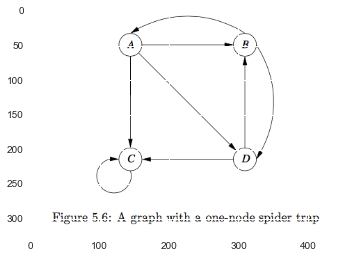

In [94]:
plt.imshow(plt.imread('./res/fig_5_6.png'))

In [95]:
M = np.array([
        [0, 1/3, 1/3, 1/3],
        [1/2, 0, 0, 1/2],
        [0, 0, 1, 0],
        [0, 1/2, 1/2, 0]
    ]).T
M

array([[ 0.        ,  0.5       ,  0.        ,  0.        ],
       [ 0.33333333,  0.        ,  0.        ,  0.5       ],
       [ 0.33333333,  0.        ,  1.        ,  0.5       ],
       [ 0.33333333,  0.5       ,  0.        ,  0.        ]])

In [100]:
np.round(dist_after_surfing(M, steps=50), 3)

array([[ 0.],
       [ 0.],
       [ 1.],
       [ 0.]])

**Solution**:       
allow each random surfer a small probability of teleporting to a random page.     
$$v = \beta M v + (1 - \beta) \frac{e}{n}$$     
where $n$ is the number of nodes in $G$, and $e$ is a vector of all 1's.

In [101]:
def dist_using_taxation(M, v=None, beta=1, steps=1):
    n = M.shape[1]
    
    if v is None:
        v = np.ones((n,1)) / n
    
    e = ones(v.shape) 
    for __ in xrange(steps):
        v = beta * M.dot(v) + (1-beta) * e / n

    return v

dist_using_taxation(M, beta=0.8, steps=30) 

array([[ 0.10135136],
       [ 0.12837839],
       [ 0.64189186],
       [ 0.12837839]])

Although C gets more than half of the PageRank for itself, the effect has been limited.

**Note** that for a random surfer, there are **three path** to move:

1. follow a link.

2. teleport to a random page. $\gets$ taxation

3. goes nowhere. $\gets$ dead ends

Since there will always be some fraction of a surfer operating on the Web, so even if there are dead ends, the sum of the ocmponents of $v$ may be less than 1, but it will never reacher 0.

#### 5.1.6 Using PageRank in a Search Engine
1. find the qualified pages, which have at least one of the search terms in the query.

2. calculate a score for those pages, including PageRank.

#### 5.1.7 Exercises

##### 5.1.1 
略

##### 5.1.2 
略

##### 5.1.3
$n$ nodes: 1/n    
the additional node: n * 1/n * 1/n = 1/n

##### 5.1.4
todo

##### 5.1.5
略

##### 5.1.6
the first node: 1    
the left nodes: 1/2

##### 5.1.7
root: 1    
height = 1:  1/3      
height = 2:  1/3 * 1/2      
height = k:  $\frac{1}{3} \times (\frac{1}{2})^{k-1}, k > 1$

### 5.2 Efficient Computation of PageRank 